# KASEN MODEL FOR SN Ia COMPANION INTERACTION 

### this is code that takes a set of simulated spectra produced by Dan Kasen according to Kasen 2010 http://adsabs.harvard.edu/abs/2010ApJ...708.1025K and integrates them through the Kepler R filter to generate lightcurves of the first 10 days os a SN explosion.  $$ $$  The simulations reproduce the effect of a companion in a single degenerate SN Ia explosion. The companion is assumed to be in Roche lobe overflow, thus its distance is determined by its mass. Three companion cases are modelled:  $$ $$ a 2 $M_\odot$ Main Sequence (MS) star,  $$ $$ a 6 $M_\odot$ MS star, and  $$ $$ a 1 $M_\odot$ Red Giant (RG).  $$ $$  Note the important note about the lightcurve shape in the last paragraph of this notebook

Time is sampled between 0.05 and 0.95 days after explosion with 0.1 days sampling intervals

In [1]:

import os,sys,glob
import numpy as np
import pylab as pl
from scipy.interpolate import interp1d
from matplotlib.ticker import ScalarFormatter
formatter=ScalarFormatter()
formatter.set_scientific(True)
formatter.set_powerlimits((-2,2))

%pylab inline


Populating the interactive namespace from numpy and matplotlib


### 40 viewing angles are simulated, between 0 and 180 degrees. $$ $$ 0 degree has the companion between us ant the WD. $$ $$ 180 has the WD between us and the companion. $$ $$ The viewing angle sampled regularly in cosine space, to give uniform elements of surface area on the sphere. 

In [2]:
angles = [167.1616,157.6685,151.0451,145.5886,140.8052,136.469,132.4543,128.6823,125.0997,121.6683, 118.3595, 115.1508, 112.0244, 108.9657, 105.9621, 103.0030, 100.0787,  97.1808,  94.3013,  91.4326,  88.5675,  85.6989,  82.8193,  79.9214,  76.9972,  74.0380,  71.0345,  67.9757,  64.8494,  61.6407,  58.3318,  54.9004,  51.3179,  47.5459,  43.5312,  39.1950,  34.4115,  28.9550,  22.3317,  12.8386]

smoothing function, hanning window

In [3]:
def smooth(x,window_len=11):
        if x.ndim != 1:
                raise ValueError, "smooth only accepts 1 dimension arrays."
        if x.size < window_len:
                raise ValueError, "Input vector needs to be bigger than window size."
        if window_len<3:
                return x

        s=numpy.r_[2*x[0]-x[window_len-1::-1],x,2*x[-1]-x[-1:-window_len:-1]]

        w=eval('numpy.hanning(window_len)')
        y=numpy.convolve(w/w.sum(),s,mode='same')
        return y[window_len:-window_len+1]

alphas and colors for plotting

In [4]:
alphas={}
for mu in angles:
    alphas[mu]=1.0-mu/max(angles)
allcolors=[ "Teal",  "YellowGreen", "Plum",  "SlateBlue", "RoyalBlue", "Tomato", "RosyBrown", "Brown",  "SeaGreen",  "Crimson", "Cyan", "DarkBlue", "DarkCyan", "DarkGreen", "DarkGray", "DarkGoldenRod", "DarkKhaki", "DarkMagenta", "DarkOliveGreen", "DarkOrange", "DarkOrchid", "DarkRed", "Olive","DarkSlateBlue", "DarkSlateGray", "DarkTurquoise",  "Purple", "DeepPink", "DeepSkyBlue", "DimGray", "DodgerBlue", "FireBrick", "Turquoise", "ForestGreen", "Fuchsia", "OliveDrab", "Gold", "GoldenRod", "Gray", "Green", "GreenYellow","IndianRed", "Indigo",  "SteelBlue", "Khaki", "Lavender",  "LawnGreen","SpringGreen",  "Lime", "LimeGreen", "Magenta", "Maroon", "MediumAquaMarine", "MediumBlue", "MediumOrchid", "MediumPurple", "MediumSeaGreen", "MediumSlateBlue", "MediumSpringGreen", "MediumTurquoise", "MediumVioletRed", "MidnightBlue",  "Navy",  "OliveDrab", "Orange", "OrangeRed", "Orchid",  "Peru", "Pink",
"SlateBlue", "Red", "RosyBrown", "RoyalBlue", "SaddleBrown", "Salmon", "SandyBrown", "Sienna", "Silver", "SkyBlue", "Purple", "SlateGray", "SpringGreen", "SteelBlue", "Tan", "Turquoise"]

### The filter is Kepler R: "Kepler-Kepler.K.dat" 

In [5]:
!pwd

/Users/fbb/LSSTall/FastTrWP/df2f7de5f48426aad266-ee2e58ad987b4de1bea399234265b9fe04eb3905


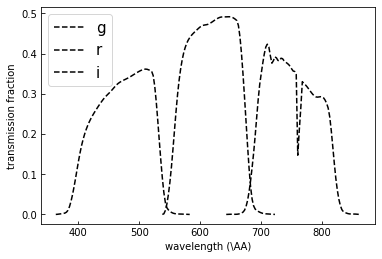

In [ ]:
myfilter = {}
filtfunc = {}

for f in ['g','r','i']:
    filterfile = '%s.txt'%f 
    #'Kepler-Kepler.K.dat'

        #used B filter for testing and comparing with Kasen 2010
    #filterfile = '/Users/fbianco/science/Dropbox/idl2/B_filter.dat'

    myfilter[f]=np.loadtxt(filterfile,unpack=True)
    filtfunc[f]=interp1d(myfilter[f][0], myfilter[f][1],bounds_error=False, fill_value=0.0)
    pl.plot(myfilter[f][0],myfilter[f][1],'k--',label="%s"%f)
    pl.xlabel(r"wavelength (\AA)")
    pl.ylabel("transmission fraction")
    pl.legend(prop={'size':15})

A distance string goes into the file names and identifies the companion. It can be: 'a5e11', that is your 2Msun MS star, 'a2e12', your 6Msun MS star, or 'a2e13', your Red Giant.

## 2 $M_\odot$ MS companion

In [14]:
dist = 'a5e11'
spdir = 'companions/companion_'+dist

#### filtering, integrating, plotting the spectra here

In [18]:
print "2 M_sun MS companion"
print "each phase is plotted in a box in each plot arrays"
print "for each phase the spectrum at the narrowest and largest viewing angles are plotted (only the narrowest is visible thought due to scaling)" 

fig1=pl.figure(figsize=(15,15))  
fig1.suptitle(r"2 $M_\odot$ MS unfiltered spectra", fontsize=20)
fig2=pl.figure(figsize=(15,15))
fig2.suptitle(r"6 $M_\odot$ MS companion spectra filtered through Kepler bandpass", fontsize=20)
lcva5e11={'epoch':[],'flux':{}}
for mu in angles:
    lcva5e11['flux'][mu]=[]
    
for t,epoch in enumerate(np.arange(0.05,10,0.1)):
    lcva5e11['epoch'].append(epoch)
    a5e11spectra={'w': np.arange(51,14852,100)}
    allspectrafiles =  np.array(glob.glob(spdir+"/optical_t%06.2f_I3.spec.*"%epoch))
    
    for mu in angles:
        thisf = [f.strip()  for f in allspectrafiles if '%.4f'%mu in f]
        a5e11spectra[mu]=np.loadtxt(thisf[0], usecols=(1,))
        
    ax1=fig1.add_subplot(10,10,t+1)
    ax2=fig2.add_subplot(10,10,t+1)            
    ax1.text(300,1500,"day: %.2f"%epoch)
    ax2.text(300,400,"day: %.2f"%epoch)
    for k in a5e11spectra.iterkeys():
        if k=='w':
            continue
        if k==167.1616:    
            ax1.plot(a5e11spectra['w']*0.1,
                     a5e11spectra[k],alpha=0.5, color=allcolors[t%10])
            ax2.plot(a5e11spectra['w']*0.1,
                     a5e11spectra[k]*filtfunc[f](a5e11spectra['w']),alpha=0.5, color=allcolors[t%10])

        if k==12.8386:    
            ax1.plot(a5e11spectra['w']*0.1,
                     a5e11spectra[k],alpha=1.0, color=allcolors[t%10])
            ax2.plot(a5e11spectra['w']*0.1,
                     a5e11spectra[k]*filtfunc[f](a5e11spectra['w']),alpha=1, color=allcolors[t%10])
    
        #integrating under the filter to get the lightcurve datapoint
        lcva5e11['flux'][k].append(sum(a5e11spectra[k]*
                                       filtfunc[f](a5e11spectra['w'])))
        
    ax1.set_ylim(0,2000)
    ax1.set_yticks([0,1000])
    ax1.set_xticks([500,1000])
    #ax1.xaxis.set_major_formatter(formatter)
    ax1.yaxis.set_major_formatter(formatter)

    ax2.plot(a5e11spectra['w']*0.1,500*filtfunc[f](a5e11spectra['w']),'k--',alpha=1)
    ax2.set_ylim(0,500)
    ax2.set_yticks([0,250])
    ax2.set_xticks([500,1000])
    #ax2.xaxis.set_major_formatter(formatter)
    ax2.yaxis.set_major_formatter(formatter)
    
    if (t)%10 == 0:
        ax1.set_ylabel("flux")
        ax2.set_ylabel("flux")

    if (t)/10 == 9:
        ax1.set_xlabel(r"wavelength ($\mu$)")
        ax2.set_xlabel(r"wavelength ($\mu$)")
        


2 M_sun MS companion
each phase is plotted in a box in each plot arrays
for each phase the spectrum at the narrowest and largest viewing angles are plotted (only the narrowest is visible thought due to scaling)


KeyError: 'companions/companion_a5e11/optical_t000.05_I3.spec.12.8386'

ValueError: Image size of 21360x103688 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1080x1080 with 1 Axes>

In [ ]:
pl.figure(figsize=(10,10))
for i,mu in enumerate(angles):
    pl.plot(lcva5e11['epoch'],lcva5e11['flux'][mu], 'k', alpha=1.0-mu/max(angles))
pl.title(r"companion: 2 $M_\odot$ MS star", fontsize=20)
pl.ylabel("flux (arbitrary units?)", fontsize=15)
pl.xlabel("days since explosion", fontsize=15)


printing file out

In [ ]:
fout=open("a5e11_Kepler.dat", "w")
print >>fout,"#phase ",
for mu in angles:
    print >>fout,"%.4f"%mu,
print >>fout,""
for i,epoch in enumerate(lcva5e11['epoch']):
    print >>fout,epoch,
    for mu in angles:
        print >>fout,"%.4f"%lcva5e11['flux'][mu][i],
    print >>fout,""
fout.close()    

## 6 $M_\odot$ MS companion

In [ ]:
dist = 'a2e12'
spdir = 'companions/companion_'+dist
   

In [ ]:
print "6 M_sun MS companion"
print "each phase is lpottted in a box in each plot arrays"
print "for each phase the spectrum at the narrowest and largest viewing angles are plotted (only the narrowest is visible thought due to scaling)" 

fig1=pl.figure(figsize=(15,15))  
fig1.suptitle(r"6 $M_\odot$ MS companion unfiltered spectra", fontsize=20)
fig2=pl.figure(figsize=(15,15))
fig2.suptitle(r"6 $M_\odot$ MS companion spectra filtered through Kepler bandpass", fontsize=20)
lcva2e12={'epoch':[],'flux':{}}
for mu in angles:
    lcva2e12['flux'][mu]=[]
    
for t,epoch in enumerate(np.arange(0.05,10.0,0.1)):
    lcva2e12['epoch'].append(epoch)
    a2e12spectra={'w': np.arange(51,14852,100)}
    allspectrafiles=  np.array(glob.glob(spdir+"/optical_t%06.2f_I3.spec.*"%epoch))

    for mu in angles:
        thisf= [f.strip()  for f in allspectrafiles if '%.4f'%mu in f]
        a2e12spectra[mu]=np.loadtxt(thisf[0], usecols=(1,))

    ax1=fig1.add_subplot(10,10,t+1)
    ax2=fig2.add_subplot(10,10,t+1)            
    ax1.text(300,1500,"day: %.2f"%epoch)
    ax2.text(300,400,"day: %.2f"%epoch)

    
    for k in a2e12spectra.iterkeys():
        if k=='w':
            continue
        if k==167.1616:    
            ax1.plot(a2e12spectra['w']*0.1,a2e12spectra[k],alpha=0.5, color=allcolors[t%10])
            ax2.plot(a2e12spectra['w']*0.1,a2e12spectra[k]*filtfunc(a2e12spectra['w']),alpha=0.5, color=allcolors[t%10])

        if k==12.8386:    
            ax1.plot(a2e12spectra['w']*0.1,a2e12spectra[k],alpha=1.0, color=allcolors[t%10])
            ax2.plot(a2e12spectra['w']*0.1,a2e12spectra[k]*filtfunc(a2e12spectra['w']),alpha=1, color=allcolors[t%10])
  
        #integrating under the filter to get the lightcurve datapoint
        lcva2e12['flux'][k].append(sum(a2e12spectra[k]*filtfunc(a2e12spectra['w'])))

    ax1.set_ylim(0,2000)
    ax1.set_yticks([0,1000])
    ax1.set_xticks([500,1000])
    #ax1.xaxis.set_major_formatter(formatter)
    ax1.yaxis.set_major_formatter(formatter)

    ax2.plot(a2e12spectra['w']*0.1,500*filtfunc(a2e12spectra['w']),'k--',alpha=1)
    ax2.set_ylim(0,500)
    ax2.set_yticks([0,250])
    ax2.set_xticks([500,1000])
    #ax2.xaxis.set_major_formatter(formatter)
    ax2.yaxis.set_major_formatter(formatter)
    
    if (t)%10 == 0:
        ax1.set_ylabel("flux")
        ax2.set_ylabel("flux")

    if (t)/10 == 9:
        ax1.set_xlabel(r"wavelength ($\mu$)")
        ax2.set_xlabel(r"wavelength ($\mu$)")
        


#### plotting the lightcurves, one for each angle. The color intensity increases as the angle decreases

Text(0.5,0,'days since explosion')

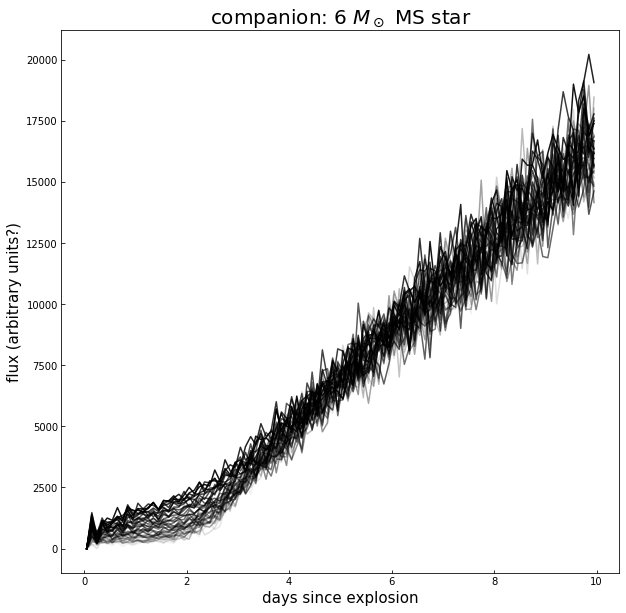

In [47]:
pl.figure(figsize=(10,10))
for i,mu in enumerate(angles):
    pl.plot(lcva2e12['epoch'],lcva2e12['flux'][mu], 'k', alpha=1.0-mu/max(angles))
pl.title(r"companion: 6 $M_\odot$ MS star", fontsize=20)
pl.ylabel("flux (arbitrary units?)", fontsize=15)
pl.xlabel("days since explosion", fontsize=15)

printing file out

In [48]:
fout=open("a2e12_Kepler.dat", "w")
print >>fout,"#phase ",
for mu in angles:
    print >>fout,"%.4f"%mu,
print >>fout,""
for i,epoch in enumerate(lcva2e12['epoch']):
    print >>fout,epoch,
    for mu in angles:
        print >>fout,"%.4f"%lcva2e12['flux'][mu][i],
    print >>fout,""
fout.close()    

## 1 $M_\odot$ RG companion

In [49]:
dist = 'a2e13'
spdir = 'companions/companion_'+dist


1 M_sun RG companion
each phase is lpottted in a box in each plot arrays
for each phase the spectrum at the narrowest and largest viewing angles are plotted (only the narrowest is visible thought due to scaling)


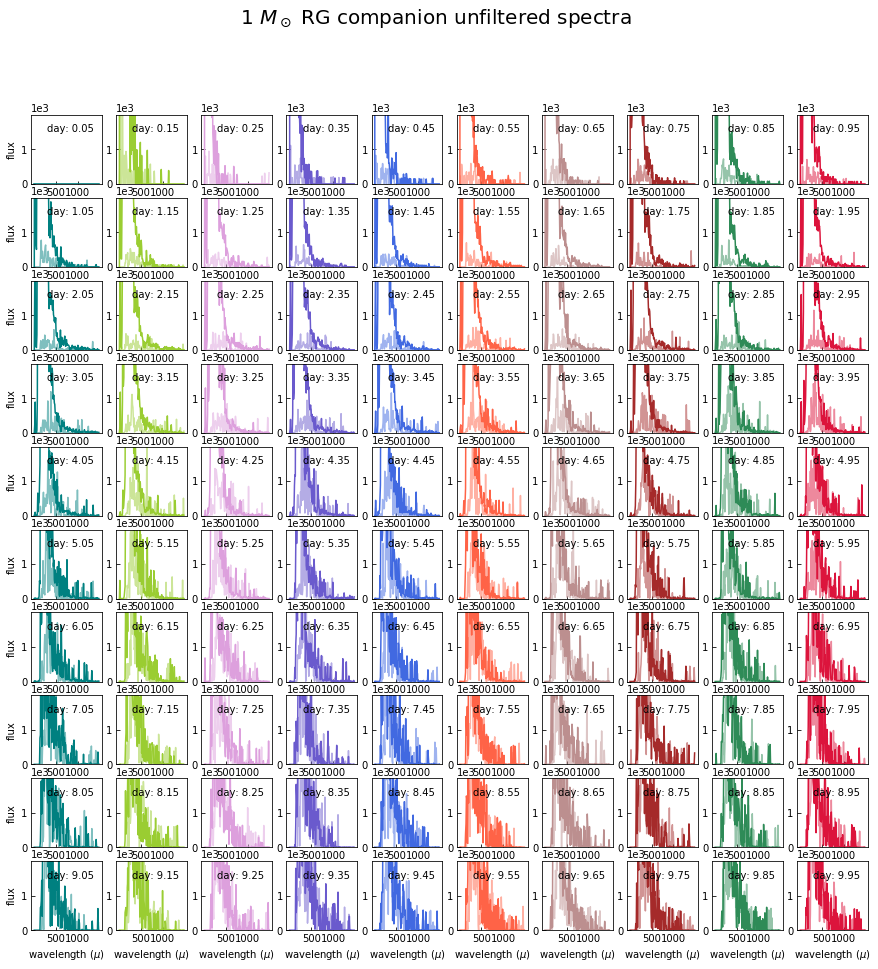

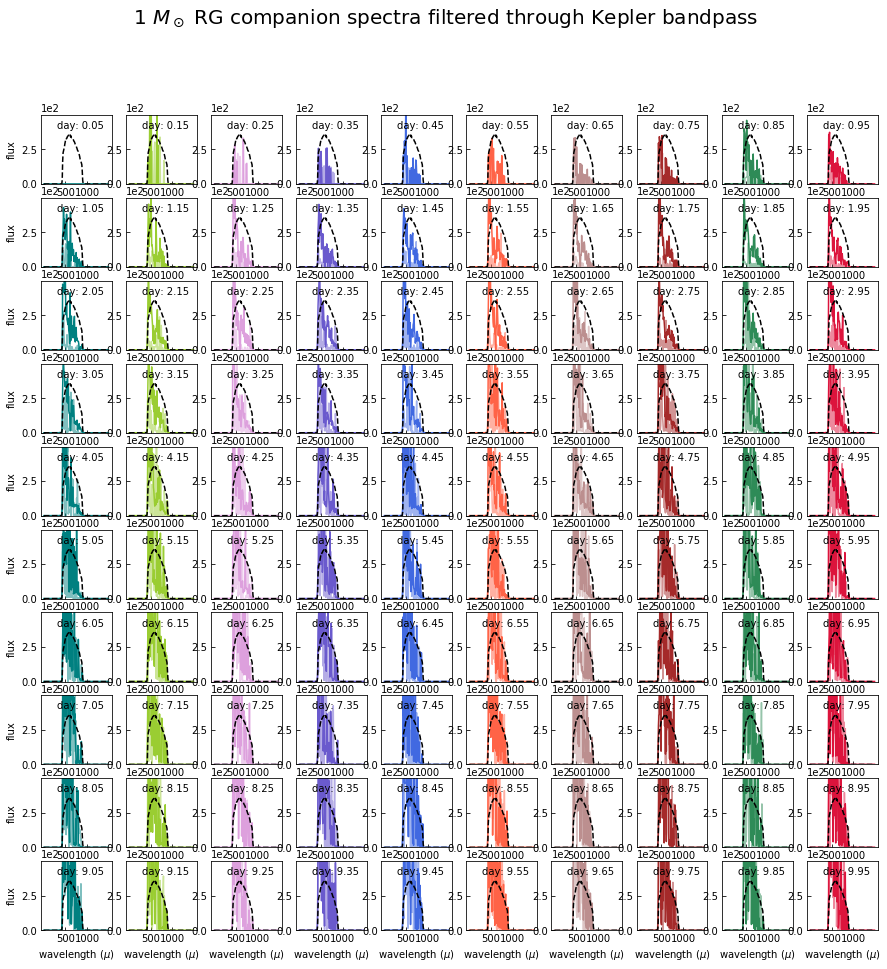

In [50]:
print "1 M_sun RG companion"
print "each phase is lpottted in a box in each plot arrays"
print "for each phase the spectrum at the narrowest and largest viewing angles are plotted (only the narrowest is visible thought due to scaling)" 


fig1=pl.figure(figsize=(15,15))  
fig1.suptitle(r"1 $M_\odot$ RG companion unfiltered spectra", fontsize=20)
fig2=pl.figure(figsize=(15,15))
fig2.suptitle(r"1 $M_\odot$ RG companion spectra filtered through Kepler bandpass", fontsize=20)
lcva2e13={'epoch':[],'flux':{}}
for mu in angles:
    lcva2e13['flux'][mu]=[]
    
for t,epoch in enumerate(np.arange(0.05,10.0,0.1)):
    lcva2e13['epoch'].append(epoch)
    a2e13spectra={'w': np.arange(51,14852,100)}
    allspectrafiles=  np.array(glob.glob(spdir+"/optical_t%06.2f_I3.spec.*"%epoch))

    for mu in angles:
        thisf= [f.strip()  for f in allspectrafiles if '%.4f'%mu in f]
        a2e13spectra[mu]=np.loadtxt(thisf[0], usecols=(1,))

    ax1=fig1.add_subplot(10,10,t+1)
    ax2=fig2.add_subplot(10,10,t+1)            
    ax1.text(300,1500,"day: %.2f"%epoch)
    ax2.text(300,400,"day: %.2f"%epoch)

    for k in a2e12spectra.iterkeys():
        if k=='w':
            continue
        if k==167.1616:    
            ax1.plot(a2e13spectra['w']*0.1,a2e13spectra[k],alpha=0.5, color=allcolors[t%10])
            ax2.plot(a2e13spectra['w']*0.1,a2e13spectra[k]*filtfunc(a2e13spectra['w']),alpha=0.5, color=allcolors[t%10])

        if k==12.8386:    
            ax1.plot(a2e13spectra['w']*0.1,a2e13spectra[k],alpha=1.0, color=allcolors[t%10])
            ax2.plot(a2e13spectra['w']*0.1,a2e13spectra[k]*filtfunc(a2e13spectra['w']),alpha=1, color=allcolors[t%10])
  
        #integrating under the filter to get the lightcurve datapoint
        lcva2e13['flux'][k].append(sum(a2e13spectra[k]*filtfunc(a2e13spectra['w'])))
        
    ax1.set_ylim(0,2000)
    ax1.set_yticks([0,1000])
    ax1.set_xticks([500,1000])
    #ax1.xaxis.set_major_formatter(formatter)
    ax1.yaxis.set_major_formatter(formatter)

    ax2.plot(a2e13spectra['w']*0.1,500*filtfunc(a2e13spectra['w']),'k--',alpha=1)
    ax2.set_ylim(0,500)
    ax2.set_yticks([0,250])
    ax2.set_xticks([500,1000])
    #ax2.xaxis.set_major_formatter(formatter)
    ax2.yaxis.set_major_formatter(formatter)
    
    if (t)%10 == 0:
        ax1.set_ylabel("flux")
        ax2.set_ylabel("flux")

    if (t)/10 == 9:
        ax1.set_xlabel(r"wavelength ($\mu$)")
        ax2.set_xlabel(r"wavelength ($\mu$)")
        

Text(0.5,0,'days since explosion')

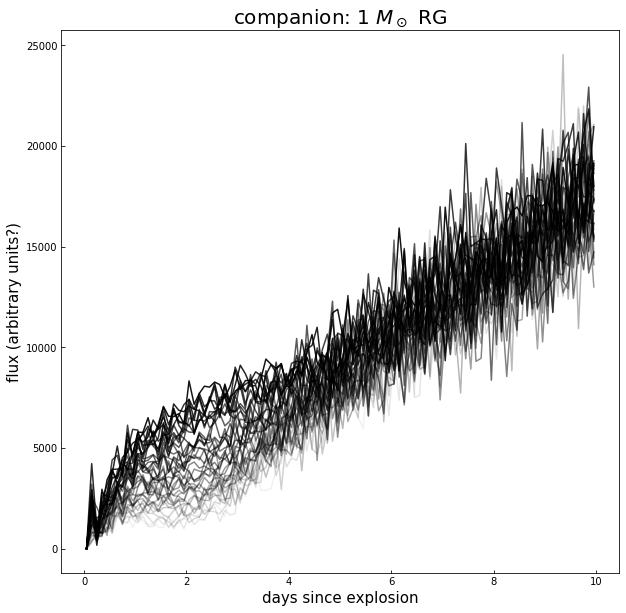

In [51]:
pl.figure(figsize=(10,10))
for i,mu in enumerate(angles):
    pl.plot(lcva2e13['epoch'],lcva2e13['flux'][mu], 'k', alpha=1.0-mu/max(angles))
pl.title(r"companion: 1 $M_\odot$ RG", fontsize=20)
pl.ylabel("flux (arbitrary units?)", fontsize=15)
pl.xlabel("days since explosion", fontsize=15)


printing file out

In [52]:
fout=open("a2e13_Kepler.dat", "w")
print >>fout,"#phase ",
for mu in angles:
    print >>fout,"%.4f"%mu,
print >>fout,""
for i,epoch in enumerate(lcva2e13['epoch']):
    print >>fout,epoch,
    for mu in angles:
        print >>fout,"%.4f"%lcva2e13['flux'][mu][i],
    print >>fout,""
fout.close()    

### now, the spectra are hella noisy, and so are the lightcurves!  $$ $$ so i am smoothing them. smoothing window is ~1 day

Text(0.5,1,'smoothed lightcurves (log scale)')

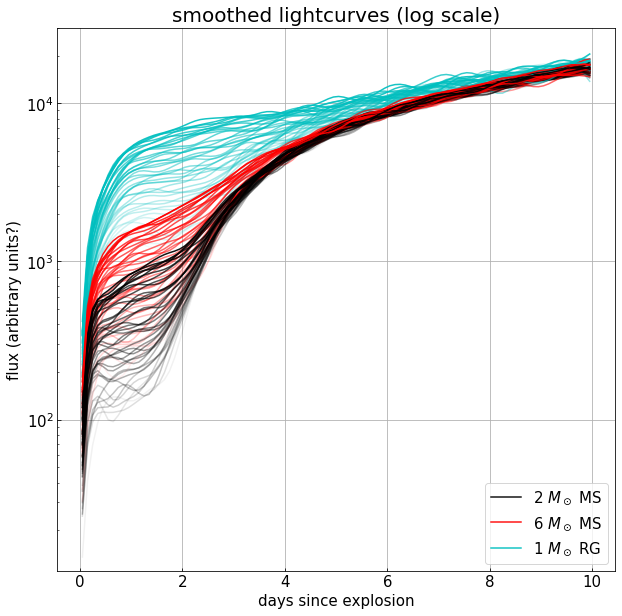

In [53]:
pl.figure(figsize=(10,10))
smoothed={'a5e11':{},'a2e12':{},'a2e13':{}}
for mu in angles:
    smoothed['a5e11'][mu]=smooth(np.array(lcva5e11['flux'][mu]),window_len=11)
    smoothed['a2e12'][mu]=smooth(np.array(lcva2e12['flux'][mu]),window_len=11)
    smoothed['a2e13'][mu]=smooth(np.array(lcva2e13['flux'][mu]),window_len=11)

for i,mu in enumerate(angles[:-1]):
    pl.plot(np.array(lcva5e11['epoch']),smoothed['a5e11'][mu], 'k', alpha=1.0-mu/max(angles))
    pl.plot(np.array(lcva2e12['epoch']),smoothed['a2e12'][mu], 'r', alpha=1.0-mu/max(angles))
    pl.plot(np.array(lcva2e13['epoch']),smoothed['a2e13'][mu], 'c', alpha=1.0-mu/max(angles))
lastmu=angles[-1]
pl.plot(np.array(lcva5e11['epoch']),smoothed['a5e11'][lastmu], 'k', alpha=1.0-lastmu/max(angles), label=r"2 $M_\odot$ MS")
pl.plot(np.array(lcva2e12['epoch']),smoothed['a2e12'][lastmu], 'r', alpha=1.0-lastmu/max(angles), label=r"6 $M_\odot$ MS")
pl.plot(np.array(lcva2e13['epoch']),smoothed['a2e13'][lastmu], 'c', alpha=1.0-lastmu/max(angles), label=r"1 $M_\odot$ RG")
pl.draw()
pl.grid()
pl.yscale('log')
pl.ylim(11,3.0e4)
pl.tick_params(axis='both', which='major', labelsize=15)
pl.legend(loc=4,prop={'size':15})
pl.ylabel("flux (arbitrary units?)",fontsize=15)
pl.xlabel("days since explosion",fontsize=15)
pl.title("smoothed lightcurves (log scale)",fontsize=20)

printing smoothed spectra out

In [54]:
for dist in ['a5e11','a2e12','a2e13']:
    fout=open("%s_Kepler_smoothed.dat"%dist, "w")
    print >>fout,"#phase ",
    for mu in angles:
        print >>fout,"%.4f"%mu,
    print >>fout,""
    
    for i,epoch in enumerate(lcva2e13['epoch']):
        print >>fout,epoch,
        for mu in angles:
            print >>fout,"%.4f"%smoothed['a5e11'][mu][i],
        print >>fout,""
    fout.close()    


## IMPORTANT: the shape of the lightcurve is weird. what we really want to characterize is the excess due to the companion, so in a way the intrinsic shape does not matter.  $$ $$ for a low mass companion at a large angle there is no excess. By removing the lightcurve derived above for the lesser mass companion for the largest viewing angle I am essencially removing the flux of the explosion in absense of this shock breakout excess.  $$ $$ This is therefore what you want to compate to the residual of your power law lightcurve rise fit. 

Text(0.5,1,'excess only time series')

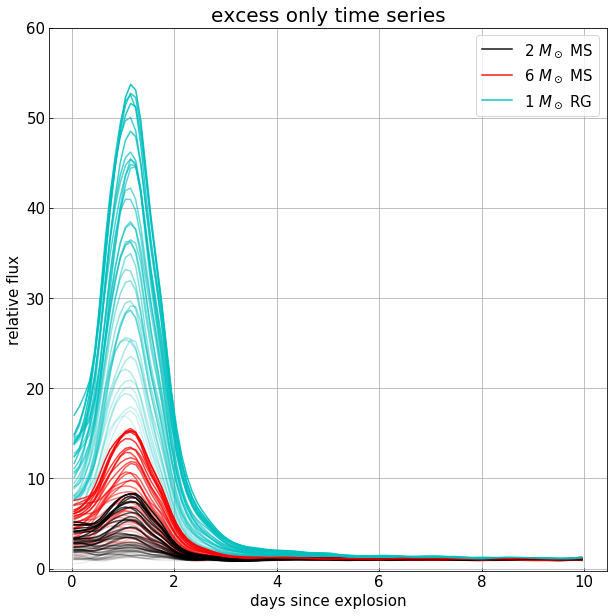

In [55]:
pl.figure(figsize=(10,10))
for i,mu in enumerate(angles[:-1]):
    pl.plot(np.array(lcva5e11['epoch']),smoothed['a5e11'][mu]/smoothed['a5e11'][angles[0]], 'k', alpha=1.0-mu/(angles[0])+0.01)
    pl.plot(np.array(lcva2e12['epoch']),smoothed['a2e12'][mu]/smoothed['a5e11'][angles[0]], 'r', alpha=1.0-mu/(angles[0])+0.01)
    pl.plot(np.array(lcva2e13['epoch']),smoothed['a2e13'][mu]/smoothed['a5e11'][angles[0]], 'c', alpha=1.0-mu/(angles[0])+0.01)
lastmu=angles[-1]
pl.plot(np.array(lcva5e11['epoch']),smoothed['a5e11'][lastmu]/smoothed['a5e11'][angles[0]], 'k', alpha=1.0-lastmu/(angles[0]), label="2 $M_\odot$ MS")
pl.plot(np.array(lcva2e12['epoch']),smoothed['a2e12'][lastmu]/smoothed['a5e11'][angles[0]], 'r', alpha=1.0-lastmu/(angles[0]), label="6 $M_\odot$ MS")
pl.plot(np.array(lcva2e13['epoch']),smoothed['a2e13'][lastmu]/smoothed['a5e11'][angles[0]], 'c', alpha=1.0-lastmu/(angles[0]), label="1 $M_\odot$ RG")
pl.draw()
pl.grid()
#pl.yscale('log')
pl.ylim(-0.3,60)
pl.tick_params(axis='both', which='major', labelsize=15)
pl.legend(prop={'size':15})
pl.ylabel("relative flux",fontsize=15)
pl.xlabel("days since explosion",fontsize=15)
pl.title("excess only time series",fontsize=20)

printing out vthe lightcurves

In [56]:
for dist in ['a5e11','a2e12','a2e13']:
    fout=open("%s_Kepler_smoothed_baselineremoved.dat"%dist, "w")
    print >>fout,"#phase ",
    for mu in angles:
        print >>fout,"%.4f"%mu,
    print >>fout,""
    
    for i,epoch in enumerate(lcva2e13['epoch']):
        print >>fout,epoch,
        for mu in angles:
            print >>fout,"%.4f"%(smoothed[dist][mu][i]/smoothed['a5e11'][angles[0]][i]),
        print >>fout,""
    fout.close()